<a href="https://akademie.datamics.com/kursliste/">![title](bg_datamics_top.png)</a><center><em>© Datamics</em></center><br><center><em>Besuche uns für mehr Informationen auf <a href='https://akademie.datamics.com/kursliste/'>www.akademie.datamics.com</a></em>

# Logistische Regression mit Python

Für diese Lektion verwenden wir den [Titanic Datensatz von Kaggle](https://www.kaggle.com/c/titanic). Dieser Datensatz ist sehr berühmt und wird oft für Studenten genutzt!

Wird werden versuchen eine Klassifizeirung vorherzusagen - überlebt oder verstorben. Beginnen wir damit unser Verständnis für die Implementierung einer logistischen Regression in Python aufzubauen.

Wir werden eine "halb-saubere" Version des Titanic-Datensatzes verwenden. Der "original" Datensatz von Kaggle braucht einige Anpassungen, die wir für euch bereits vorgenommen haben. Ihr findet alle Dateien in den Kursunterlagen.

## Libraries importieren

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Die Daten

Beginnen wir damit die Datei "titanic_train.csv" in einen Pandas DataFrame zu laden.

In [2]:
train = pd.read_csv('titanic_train.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Explorative Datenanalyse

Wir können uns jetzt besser mit dem Datensatz vertraut machen! Wir starten damit nach fehlenden Daten zu schauen.

### Fehlende Daten (en. missing data)

Wir können Seaborn verwenden um eine simple Heatmap zu erzeugen, die uns zeigt, wo Datenpunkte fehlen.

<AxesSubplot:>

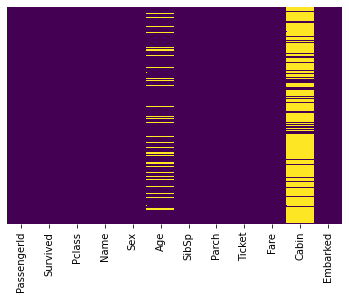

In [4]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Ungefähr 20 Prozent der Altersdaten (en. age data) fehlt. Der Anteil wahrscheinlich noch klein genug, um eine sinnvolle Ersetzung der fehlende Werte vorzunehmen. Wenn wir auf die Kabinenspalte (en. cabin column) schauen stellen wir etwas anderes fest. Es scheint als würden wir hier zu viele Datenpunkte auslassen, um eine vernünftige Ersetzung vorzunehmen. Wahrscheinlich werden wir diese Spalte später auslassen oder die Information umwandeln. Z.B. in eine neue Spalte "Cabin Known" (dt. Kabine bekannt), die 1 oder 0 beinhaltet.

Fahren wir damit vor einige der Spalten zu visualisieren, um ein Gefühl für die Daten zu bekommen. Für die vollständigen Erklärungen dient das Video. Dieser Code dient insbesondere als Referenz.

<AxesSubplot:xlabel='Survived', ylabel='count'>

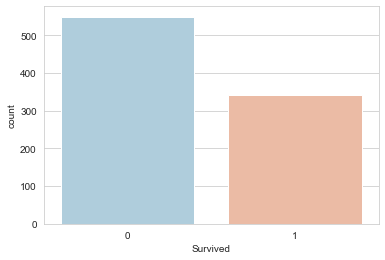

In [5]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train,palette='RdBu_r')

<AxesSubplot:xlabel='Survived', ylabel='count'>

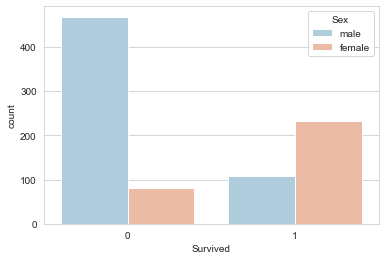

In [6]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train,palette='RdBu_r')

<AxesSubplot:xlabel='Survived', ylabel='count'>

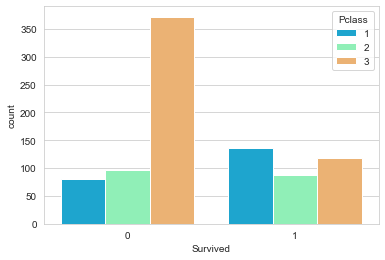

In [7]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=train,palette='rainbow')

<AxesSubplot:xlabel='Age', ylabel='Count'>

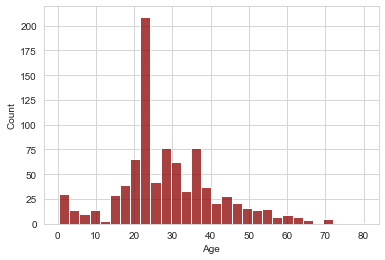

In [33]:
sns.histplot(train['Age'].dropna(),kde=False,color='darkred',bins=30)

<AxesSubplot:>

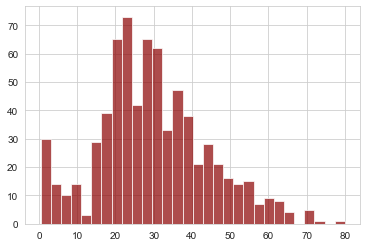

In [9]:
train['Age'].hist(bins=30,color='darkred',alpha=0.7)

<AxesSubplot:xlabel='SibSp', ylabel='count'>

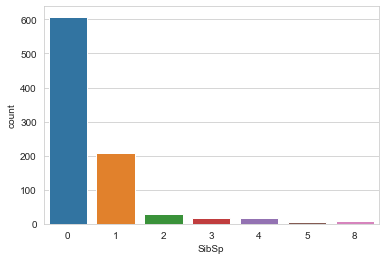

In [10]:
sns.countplot(x='SibSp',data=train)

<AxesSubplot:>

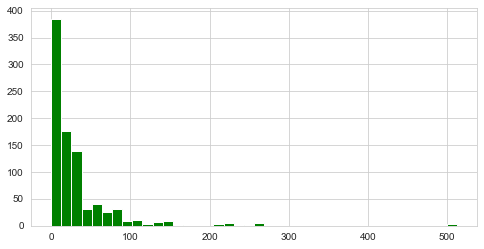

In [11]:
train['Fare'].hist(color='green',bins=40,figsize=(8,4))

### Cufflinks für Diagramme

Nehmen wir uns kurz die Zeit für ein Beispiel mit Cufflinks!

In [12]:
import cufflinks as cf
cf.go_offline()

In [13]:
train['Fare'].iplot(kind='hist',bins=30,color='green')

## Datenbereinigung

Wir wollen die fehlenden Altersdaten ersetzen anstatt die Zeilen mit fehlenden Werten einfach zu löschen. Eine Möglichkeit dies zu tun wäre das durchschnittliche Alter aller Passagiere einzufügen (Imputation). Wir können allerdings noch einen Schritt genauer vorgehen und das durchschnittliche Alter der entsprechenden Klasse einfügen. Zum Beispiel:

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

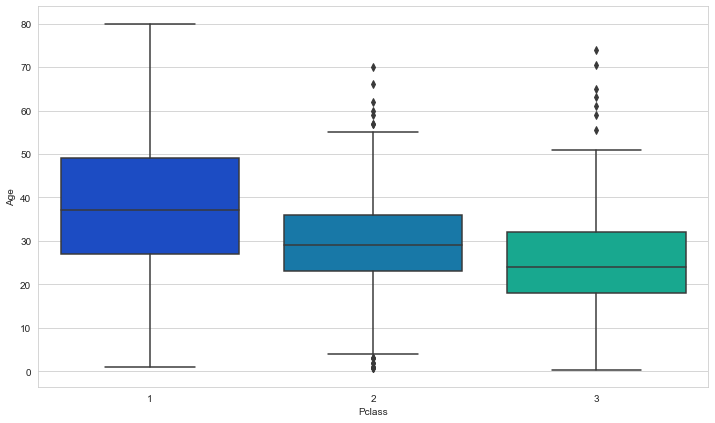

In [14]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

Wir sehen, dass die wohlhabenderen Passagiere in den höheren Klassen dazu tendieren älter zu sein. Dies ergibt vollkommen Sinn. Wir nutzen diese Durchschnitte nun, um das Alter anhand der Pclass einzusetzen.

In [15]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

Jetzt wenden wir diese Funktion an!

In [16]:
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)

Schauen wir uns nun erneut die Heatmap an!

<AxesSubplot:>

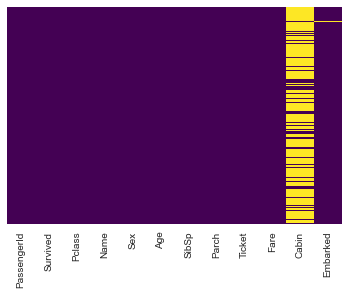

In [17]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Großartig! Jetzt können wir die Kabinenspalte löschen und die Zeile, in der ein Wert bei "Embarked" fehlt:

In [18]:
train.drop('Cabin',axis=1,inplace=True)

In [19]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [20]:
train.dropna(inplace=True)

## Kategorische Inhalte umwandeln

Wir müssen nun kategorische Inhalte mit Pandas zu Dummy Variablen umwandeln. Andernfalls könnte unser Machine Learning Algorithmus nicht mit ihnen arbeiten!

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [22]:
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)

In [23]:
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [24]:
train = pd.concat([train,sex,embark],axis=1)

In [25]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


Toll! Jetzt sind unsere Daten bereit für unser Modell!

## Ein Modell zur logistischen Regression erstellen

Beginnen wir damit unsere Daten in ein Trainings- und Testset aufzuteilen (Es gibt auch noch eine test.csv Datei, falls du alle Daten aus diesem Datensatz zum trainieren verwenden möchtest).

### Train Test Split

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1), 
                                                    train['Survived'], test_size=0.30, 
                                                    random_state=101)

### Training und Vorhersage

In [28]:
from sklearn.linear_model import LogisticRegression

In [34]:
logmodel = LogisticRegression(max_iter=1000)
logmodel.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [35]:
predictions = logmodel.predict(X_test)

Fahren wir nun damit fort unser Modell zu auszuwerten!

### Auswertung
Wir können die precision, recall und f1-score mit `classification report` auswerten! [Hier](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support) sind weitere Informationen zur auswertung des `classification reports`

In [36]:
from sklearn.metrics import classification_report

In [37]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       163
           1       0.84      0.68      0.75       104

    accuracy                           0.82       267
   macro avg       0.83      0.80      0.81       267
weighted avg       0.83      0.82      0.82       267



Gar nicht so schlecht! Evtl. möchtest du noch weitere Eigenschaften ins Modell aufnehmen. Zum ausprobieren haben wir folgende Vorschläge vorbereitet:
* Versuche den Titel einer Person (Dr.,Mr.,Mrs.,etc...) aus dem Namen in ein Feature umzuwandeln
* Vielleicht spielt der Buchstabe der Kabine eine Rolle
* Kannst du Informationen aus dem Ticket erhalten?

# Gut gemacht!